# Testing strategy

## SIR Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
%matplotlib inline
from sir_inference.inference_model import InferenceModel
from sir_inference.sir_model import ProximityModel
from ipywidgets import interact, IntSlider

In [2]:
# seed for reproducibility
np.random.seed(878)

In [3]:
N = 4000 #number of individuals
N_patient_zero = 20 #number of patients 0
scale = 1.0 #scale of the graphs
mu = 0.01 # mu -> recover
lamb = 0.02 # lamb -> transmission

# creating list of patients 0
List_patient_zero = np.random.randint(N, size=N_patient_zero)
initial_states = np.zeros(N)
initial_states[List_patient_zero] = 1

In [4]:
model = ProximityModel(N, scale, mu, lamb, initial_states)
print("expected number of contacts %.1f" % model.n_contacts)
model.run(300, print_every=50)

expected number of contacts 6.0
Generating transmissions
Running simulation
t = 0 / 300
t = 50 / 300
t = 100 / 300
t = 150 / 300
t = 200 / 300
t = 250 / 300


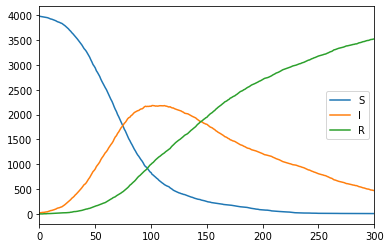

In [5]:
counts = model.get_counts()
counts.plot();

## (Past) Observations

Let's say we have done a series of random tests in the past, which gives us our past observations.

In [6]:
def generate_observations(model, tests):
    observations = []
    for t_test, n_test in tests.items():
        tested = np.random.choice(model.N, n_test, replace=False)
        for i in tested:
            obs = dict(i=i, t_test=t_test, s=model.states[t_test,i])
            observations.append(obs)
    return observations

In [7]:
t_test = 50 # T_TEST IS HERE
tests = {t: t//2 for t in range(t_test)}
past_observations = generate_observations(model, tests)
print("number of past observations", len(past_observations))

number of past observations 600


## Scenario 

Let's say at time `t_test` we have `n_test` of individuals returned positive to the virus. We have a limited budget of `n_new_test` to perform and we want to efficently target the tests.

We compare two testing strategies

1. naive contact tracing : say we list all the person that have been in contact with the known infected inviduals
2. use inference to estimate the probalities and provide a list of the most probably infected persons

Remarks
- we don't know when they got infected. Maybe in another scenario we can have an informed estimate of that time (eg based on symptoms or other features). Here will do a coarse approximation and say they were all infected at time t_test - tau, where tau is chosen.
- for strategy 1, I don't know the rule for contact tracing. Here we simply list all past contacts of the tested people, say during t_test - tau and t_test, and count the number of encounters.

In [8]:
n_test = 100 
tau = 5

In [9]:
# get last infected and tested people
last_infected, = np.where(model.states[t_test,:] == 1)
last_tested = list(last_infected[:n_test])
n_last_infected = len(last_infected)
n_last_tested = len(last_tested)
print(f"n_last_infected = {n_last_infected} n_last_tested = {n_last_tested}")
# get past tested people (observed infected in past_observations)
past_tested = [obs["i"] for obs in past_observations if obs["s"]==1]
full_tested = last_tested + past_tested
n_full_tested = len(full_tested)
print(f"n_full_tested = {n_full_tested}")
# targets : last infected people, but not tested yet
target = [i for i in last_infected if i not in full_tested]
n_target = len(target)
print(f"remaining infected people to detect n_target={n_target}")
if (n_target==0):
    raise ValueError("Choose other parameters or rerun, no target left to detect")

n_last_infected = 906 n_last_tested = 100
n_full_tested = 172
remaining infected people to detect n_target=749


In [10]:
# pool to target : everyone except already tested
actual_status = pd.DataFrame(
    dict(i=i, s=s, infected=1*(s==1)) 
    for i, s in enumerate(model.states[t_test])
    if i not in full_tested
)
actual_status.groupby('s').size()

s
0.0    2939
1.0     749
2.0     148
dtype: int64

## Strategy 1

In [11]:
def csr_to_list(x):
    x_coo = x.tocoo()
    return zip(x_coo.row, x_coo.col, x_coo.data)

# get past contacts of last_tested people
contacts = pd.DataFrame(
    dict(i=i, j=j, t=t) 
    for t in range(t_test - tau, t_test)
    for i, j, _ in csr_to_list(model.transmissions[t])
    if j in last_tested and i not in full_tested
)
encounters = contacts.groupby("i").size().rename("count").reset_index()
encounters = pd.merge(encounters, actual_status, on="i", how="inner")
encounters = encounters.sort_values(by="count", ascending=False)
encounters["rank"] = range(encounters.shape[0])
encounters["total_infected"] = encounters["infected"].cumsum()
encounters.head()

,i,count,s,infected,rank,total_infected
1018,3258,11,1.0,1,0,1
767,2492,11,1.0,1,1,2
469,1535,10,0.0,0,2,2
914,2943,10,0.0,0,3,2
772,2502,10,1.0,1,4,3


In [12]:
for t in range(t_test - tau, t_test):
    print("t=",t)
    for i, j, _ in csr_to_list(model.transmissions[t]):
        if (i==151):
            if (model.states[t][j]==1):
                print(i,j)



t= 45
t= 46
t= 47
t= 48
t= 49


## Strategy 2

Let's say we start the inference at t_start, and use the actual frequencies 
as the initial proba.

In [13]:
def generate_initial_probas(states):
    "generate initial proba according to the freq of states"
    freqs = [np.mean(states==s) for s in [0,1,2]]
    print("freqs = ", freqs)
    N = len(states)
    initial_probas = np.broadcast_to(freqs, (N, 3)).copy()
    return initial_probas

#The value of t_start below decides when we initialize the probas
t_start=0
initial_probas = generate_initial_probas(states=np.zeros(N))
#initial_probas = generate_initial_probas(states=model.states[t_start])
infer = InferenceModel(initial_probas, model.x_pos, model.y_pos)

freqs =  [1.0, 0.0, 0.0]


The observations are the n_test tests at time t_test + past observations.

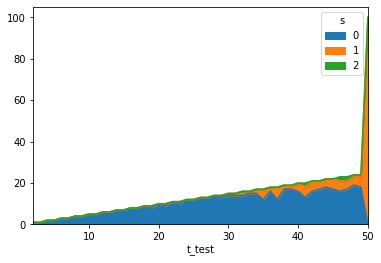

In [14]:
last_observations = [dict(i=i, t_test=t_test, s=1) for i in last_tested]
observations = past_observations + last_observations
for obs in observations:
    obs["s"] = int(obs["s"])
    obs["tau"] = tau
df_full_obs = pd.DataFrame(observations)
df_full_obs.groupby(["t_test", "s"]).size().unstack("s").plot.area(stacked=True);

**Warning** One must be careful to shift the transmissions and the observations by t_start

In [15]:
transmissions = model.transmissions[t_start:]
for obs in observations:
    obs["t"] = obs["t_test"]-t_start
    obs["t_I"] = obs["t"] - obs["tau"]
infer.time_evolution(model.recover_probas, transmissions, observations, print_every=100)

t = 0 / 300
t = 100 / 300
t = 200 / 300


In [16]:
# most probably infected
probas_I = pd.DataFrame(
    dict(i=i, p=p) 
    for i, p in enumerate(infer.probas[t_test-t_start,:,1])
    if i not in full_tested
)
probas_I = pd.merge(probas_I, actual_status, on="i", how="inner")
probas_I = probas_I.sort_values(by="p", ascending=False)
probas_I["rank"] = range(probas_I.shape[0])
probas_I["total_infected"] = probas_I["infected"].cumsum()
probas_I.head()

,i,p,s,infected,rank,total_infected
105,127,0.734159,2.0,0,0,0
2726,2875,0.728771,2.0,0,1,0
2743,2893,0.722184,1.0,1,2,1
3701,3863,0.705482,1.0,1,3,2
2162,2296,0.705426,2.0,0,4,2


## Comparison

In [17]:
def get_random_guess():
    random_ranking = [i for i in np.random.permutation(model.N) if i not in full_tested]
    df = pd.DataFrame({"i": random_ranking})
    df["rank"] = range(df.shape[0])
    df = pd.merge(df, actual_status, on="i", how="inner")
    df = df.sort_values(by="rank")
    df["total_infected"] = df["infected"].cumsum()
    return df

random_guess = get_random_guess()

n_target = 749


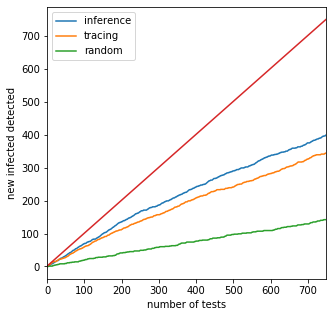

In [18]:
print(f"n_target = {n_target}")

fig, ax = plt.subplots(1,1,figsize=(5,5))
probas_I.plot(ax=ax, x="rank", y="total_infected", label="inference")
encounters.plot(ax=ax, x="rank", y="total_infected", label="tracing")
random_guess.plot(ax=ax, x="rank", y="total_infected", label="random")
ax.set(ylabel="new infected detected", xlabel="number of tests")
ax.plot([0,n_target], [1,n_target+1])
ax.set_xlim(0, n_target);
plt.savefig("comparison_npo360_dtinit60")

## Counts est vs actual

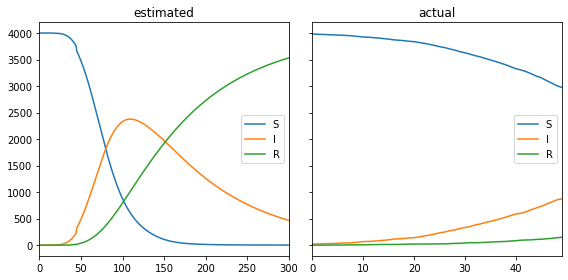

In [19]:
fig, axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
counts_est = infer.get_counts()
counts_est.index += t_start
counts_est.plot(ax=axs[0])
axs[0].set_title("estimated")
counts[t_start:t_test].plot(ax=axs[1])
axs[1].set_title("actual")
fig.tight_layout()

In [20]:
assert np.allclose(infer.probas.sum(axis=2),1)
assert infer.probas.min()>=0
assert infer.probas.max()<=1

## Tables

In [21]:
n_untested = model.N - n_full_tested
print(f"n_full_tested = {n_full_tested}, n_last_infected={n_last_infected}, n_untested={n_untested}")

n_full_tested = 172, n_last_infected=906, n_untested=3828


In [22]:
def time_evo_proba(i):
    evo = pd.DataFrame(infer.probas[:,i,:], columns=["S","I","R"])
    evo.index.name="t"
    evo.plot(title=f"i={i}");

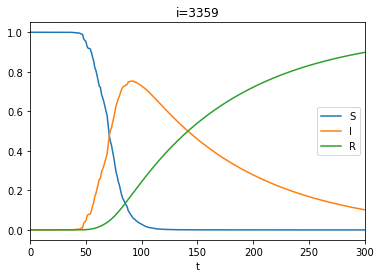

In [23]:
time_evo_proba(3359)

In [24]:
merged = pd.merge(encounters, probas_I, on=["i","infected","s"], how="inner",suffixes=["_1","_2"])
merged.sort_values(by="rank_1").head(20)

,i,count,s,infected,rank_1,total_infected_1,p,rank_2,total_infected_2
0,3258,11,1.0,1,0,1,0.462581,107,73
1,2492,11,1.0,1,1,2,0.425548,142,92
2,1535,10,0.0,0,2,2,0.435542,134,86
3,2943,10,0.0,0,3,2,0.328823,295,183
4,2502,10,1.0,1,4,3,0.476433,96,67
5,3683,10,1.0,1,5,4,0.539347,56,38
6,1802,10,1.0,1,6,5,0.300913,354,216
7,2987,10,2.0,0,7,5,0.000000,3829,749
8,2443,10,1.0,1,8,6,0.310076,335,205
9,2454,10,1.0,1,9,7,0.381839,196,134


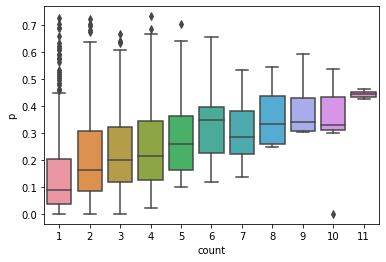

In [25]:
import seaborn as sns
sns.boxplot(x="count", y="p", data=merged);

In [26]:
merged.iloc[0:10].mean()

i                   2609.90000
count                 10.20000
s                      0.90000
infected               0.70000
rank_1                 4.50000
total_infected_1       3.70000
p                      0.36611
rank_2               554.40000
total_infected_2     184.30000
dtype: float64

In [27]:
merged.head()

,i,count,s,infected,rank_1,total_infected_1,p,rank_2,total_infected_2
0,3258,11,1.0,1,0,1,0.462581,107,73
1,2492,11,1.0,1,1,2,0.425548,142,92
2,1535,10,0.0,0,2,2,0.435542,134,86
3,2943,10,0.0,0,3,2,0.328823,295,183
4,2502,10,1.0,1,4,3,0.476433,96,67


In [28]:
id_=3523

In [29]:
infer.probas[t_test-t_start][id_]

array([0.58593939, 0.39643523, 0.01762537])

In [30]:
prob_in_time = []
times = [] 
for o in range(20):
    print(o," ",infer.probas[t_test-t_start-o][id_])
    prob_in_time.append(infer.probas[t_test-t_start-o][id_][1])
    times.append(20-o)

0   [0.58593939 0.39643523 0.01762537]
1   [0.63223715 0.35367422 0.01408863]
2   [0.68910755 0.29980184 0.01109061]
3   [0.74406624 0.24731631 0.00861745]
4   [0.80068695 0.19262182 0.00669123]
5   [0.83364862 0.16127288 0.0050785 ]
6   [0.86059223 0.13568613 0.00372164]
7   [0.88447725 0.11293041 0.00259234]
8   [0.908392   0.08991481 0.00169319]
9   [0.92487139 0.0741772  0.00095142]
10   [9.68056470e-01 3.13051629e-02 6.38366817e-04]
11   [9.76448826e-01 2.31442496e-02 4.06924321e-04]
12   [9.85258295e-01 1.44795768e-02 2.62128553e-04]
13   [9.87869717e-01 1.19880352e-02 1.42248201e-04]
14   [9.93058956e-01 6.86747078e-03 7.35734935e-05]
15   [9.95767919e-01 4.20051303e-03 3.15683632e-05]
16   [9.97993424e-01 1.99495729e-03 1.16187903e-05]
17   [9.99440732e-01 5.53180524e-04 6.08698508e-06]
18   [9.99487370e-01 5.11659464e-04 9.70390438e-07]
19   [9.99934641e-01 6.50390055e-05 3.20000384e-07]


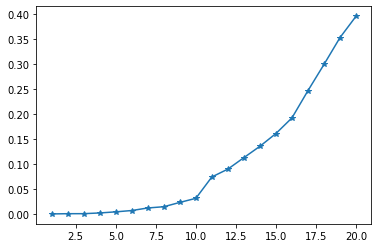

In [31]:
plt.plot(times,prob_in_time,'*-')